<a href="https://colab.research.google.com/github/annykay/NoiseInDataImpact/blob/main/MLbasedImputation/MissingTargetsAndImputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor


In [37]:
def plot_results(result, datasetname, inputation, test = True):
    plt.figure(figsize=(10,8))
    plt.plot([i/20 for i in range(20)], np.array(result)[:,0], label = 'DTC')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,1], label = 'RFC')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,2], label = 'KNN')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,3], label = 'XGB')
    plt.plot([i/20 for i in range(20)], np.array(result)[:,4], label = 'LRC')
    if test:
        plt.title('{} DataSet(Test). Target Corruption. {} Imputation'.format(datasetname, inputation))
    else:
        plt.title('{} DataSet(Train). Target Corruption. {} Imputation'.format(datasetname, inputation))
    plt.xlabel('Drop Level')
    plt.ylabel('F1 score')
    plt.grid()
    plt.legend()
    plt.show()

In [38]:
def plot_all_results(result_lr, result_dt, result_knn, result_extra, dataset, test = True):
    plt.figure(figsize=(10,8))
    imps = ['LR', 'RFR', 'KNR', 'ETR']
    styles = ['-', '--', ':', '-.']
    for result, imp, st in zip([result_lr, result_dt, result_knn, result_extra], imps,styles):
        plt.plot([i/20 for i in range(20)], np.array(result)[:,0], color = 'b', 
                 linestyle = st, label = 'DTC, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,1], color = 'y', 
                 linestyle = st, label = 'RFC, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,2], color = 'g', 
                 linestyle = st, label = 'KNN, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,3], color = 'r',
                 linestyle = st, label = 'XGB, {} Imputation'.format(imp))
        plt.plot([i/20 for i in range(20)], np.array(result)[:,4], color = 'm', 
                 linestyle = st, label = 'LRC, {} Imputation'.format(imp))
    if test:
        plt.title('{} DataSet(Test). Target Corruption'.format(dataset))
    else:
        plt.title('{} DataSet(Train). Target Corruption'.format(dataset))
    plt.xlabel('Drop Level')
    plt.ylabel('F1 score')
    plt.grid()
    plt.legend()

In [39]:
def corupt_important_features(n, X, y, important, clfs, est):
    Train_Scores = []
    Test_Scores = []
    features = [i for i in range(X.shape[1])]
    not_important = [i  for i in features if i not in important] 
    print(not_important)
    for i in range(n):
        level = i/n
        print(level)
        D = X.copy()
        imp = IterativeImputer(estimator = est, max_iter=3, random_state=0)
        mask = np.random.binomial(1, level, size=(D.shape[0],D.shape[1]))
        mask[:, not_important] = 0
        mask = mask.astype(bool)
        D[mask] = np.nan
        X_train, X_test, y_train, y_test = train_test_split(
             D, y, test_size=0.7, random_state=0)
    
        imp.fit(X_train)
        X_train = imp.transform(X_train)
        X_test = imp.transform(X_test)
    
        scores = Scores(clfs, X_train, X_test, y_train, y_test)
        print(scores)
    
        Train_Scores.append(scores[0])
        Test_Scores.append(scores[1])
        
    return (Train_Scores, Test_Scores)

# Indexes of Important Features were Obtained from my Teammates' analysis 
important_pulsar = [2,3]
important_stellar = [-3]
important_rice = [1,3,4,-1]
important_bank = [1,3,4,-1]

In [40]:

X = pd.read_csv('Pulsars_features.csv', index_col= 0)
y = pd.read_csv('Pulsars_labels.csv', index_col = 0)


tree = DecisionTreeClassifier(random_state=0, max_depth = 2)
forst = RandomForestClassifier(random_state=0, n_jobs = -1, max_depth= 7,  n_estimators = 10, max_features = 6)
ada = AdaBoostClassifier(learning_rate= 0.6, n_estimators=50)
knn = KNeighborsClassifier(n_neighbors = 9, n_jobs=-1)
xgvClf = xgb.XGBClassifier(random_state=0, learning_rate=0.3, max_depth = 3, n_estimators=70, )
logReg = LogisticRegression(random_state=0, C=12, n_jobs = -1)


clfs = [tree,
        forst, 
        knn,
        xgvClf,
        logReg
       ]

def Scores(clfs, X_train, X_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    importances = []
    for reg in clfs:
        reg.fit(X_train, y_train)
        y_train_pred = reg.predict(X_train)
        y_test_pred = reg.predict(X_test)
        train_score = round(f1_score(y_train, y_train_pred, average='micro'), 2)
        test_score = round(f1_score(y_test, y_test_pred, average='micro'), 2)
        
        train_scores.append(train_score)
        test_scores.append(test_score)

    return train_scores, test_scores

def corrupt_target(n, X, y, clfs, est):
  Train_Scores = []
  Test_Scores = []

  for i in range(20):
    level = i/20
    print(level)
    Y = y.copy()
    imp = IterativeImputer(estimator = est, max_iter=3, random_state=0)
    mask = np.random.binomial(1, level, size=(Y.shape[0],Y.shape[1])).astype(bool)
    Y[mask] = np.nan
    X_train, X_test, y_train, y_test = train_test_split(
         X, Y, test_size=0.7, random_state=0)
    
    
    imp.fit(y_train)
    y_train = np.round(imp.transform(y_train), 0)
    y_test = np.round(imp.transform(y_test), 0)

    
    scores = Scores(clfs, X_train, X_test, y_train, y_test)
    print(scores)
    
    Train_Scores.append(scores[0])
    Test_Scores.append(scores[1])
  return (Train_Scores, Test_Scores)

In [41]:
pulsar_train, pulsar_test = corrupt_target(20, X, y, clfs, est = None)
pd.DataFrame(pulsar_train).to_csv('PulsarF1TrainScores.csv', index = False)
pd.DataFrame(pulsar_test).to_csv('PulsarF1TestScores.csv', index = False)

0.0
([0.98, 0.99, 0.97, 0.99, 0.98], [0.98, 0.98, 0.97, 0.98, 0.98])
0.05
([0.98, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.97, 0.97, 0.97])
0.1
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.97, 0.97, 0.97])
0.15
([0.97, 0.98, 0.97, 0.99, 0.97], [0.97, 0.96, 0.96, 0.96, 0.96])
0.2
([0.97, 0.99, 0.97, 0.99, 0.97], [0.96, 0.96, 0.96, 0.96, 0.96])
0.25
([0.97, 0.99, 0.97, 0.99, 0.97], [0.96, 0.96, 0.95, 0.96, 0.96])
0.3
([0.97, 0.98, 0.96, 0.99, 0.96], [0.96, 0.96, 0.95, 0.95, 0.95])
0.35
([0.97, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.4
([0.96, 0.99, 0.96, 0.99, 0.95], [0.95, 0.95, 0.95, 0.95, 0.95])
0.45
([0.96, 0.99, 0.96, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.5
([0.96, 0.99, 0.97, 0.99, 0.95], [0.95, 0.95, 0.95, 0.95, 0.95])
0.55
([0.96, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.6
([0.97, 0.99, 0.97, 0.99, 0.96], [0.96, 0.96, 0.96, 0.96, 0.96])
0.65
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.97, 0.97, 0.97])
0.7
([0.98, 0.99, 0.98, 0.9

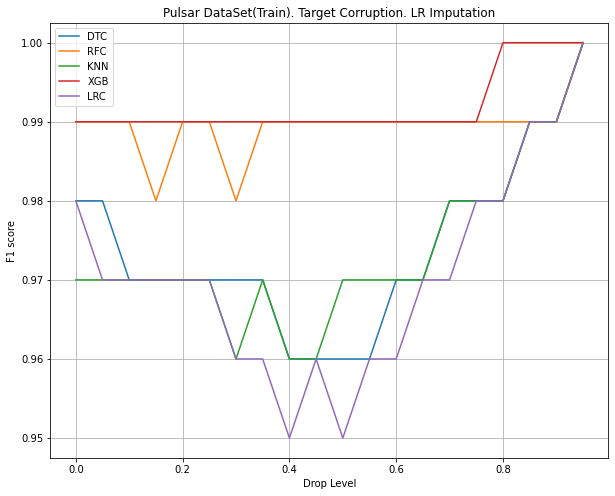

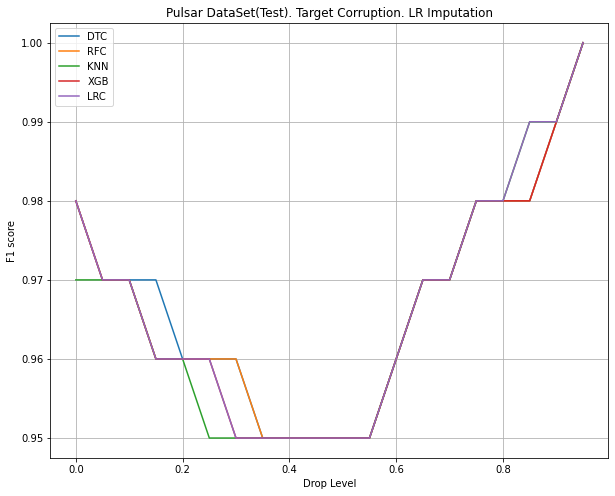

In [42]:
plot_results(pulsar_train, 'Pulsar', 'LR', test = False)
plot_results(pulsar_test, 'Pulsar', 'LR', test = True)

0.0
([0.98, 0.99, 0.97, 0.99, 0.98], [0.98, 0.98, 0.97, 0.98, 0.98])
0.05
([0.98, 0.99, 0.97, 0.99, 0.98], [0.97, 0.97, 0.97, 0.97, 0.97])
0.1
([0.97, 0.98, 0.97, 0.99, 0.97], [0.97, 0.97, 0.96, 0.97, 0.97])
0.15
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.96, 0.97, 0.97])
0.2
([0.97, 0.98, 0.97, 0.99, 0.97], [0.96, 0.96, 0.96, 0.96, 0.96])
0.25
([0.96, 0.98, 0.96, 0.99, 0.96], [0.95, 0.96, 0.95, 0.95, 0.96])
0.3
([0.96, 0.98, 0.96, 0.99, 0.96], [0.96, 0.96, 0.95, 0.95, 0.95])
0.35
([0.96, 0.99, 0.97, 0.99, 0.96], [0.96, 0.95, 0.95, 0.95, 0.96])
0.4
([0.96, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.45
([0.96, 0.99, 0.96, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.5
([0.96, 0.99, 0.96, 0.99, 0.95], [0.95, 0.95, 0.95, 0.95, 0.95])
0.55
([0.97, 0.99, 0.97, 0.99, 0.96], [0.96, 0.95, 0.96, 0.95, 0.95])
0.6
([0.96, 0.99, 0.97, 0.99, 0.96], [0.97, 0.96, 0.96, 0.96, 0.96])
0.65
([0.97, 0.99, 0.97, 0.99, 0.96], [0.96, 0.96, 0.96, 0.96, 0.96])
0.7
([0.98, 0.99, 0.98, 1.0

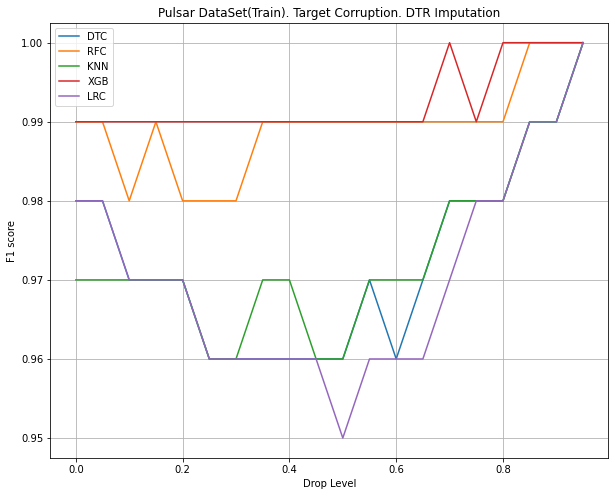

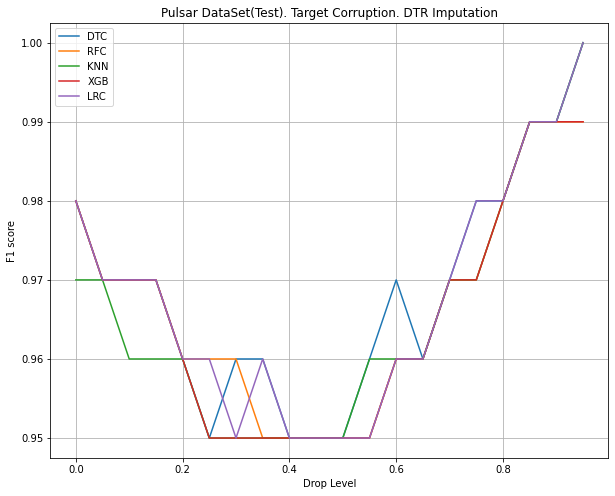

In [43]:
pulsar_train_dt, pulsar_test_dt = corrupt_target(20, X, y, clfs, est = DecisionTreeRegressor())
pd.DataFrame(pulsar_train_dt).to_csv('PulsarF1TrainScoresDT.csv', index = False)
pd.DataFrame(pulsar_test_dt).to_csv('PulsarF1TestScoresDT.csv', index = False)
plot_results(pulsar_train_dt, 'Pulsar', 'DTR', test = False)
plot_results(pulsar_test_dt, 'Pulsar', 'DTR', test = True)

0.0
([0.98, 0.99, 0.97, 0.99, 0.98], [0.98, 0.98, 0.97, 0.98, 0.98])
0.05
([0.98, 0.99, 0.97, 0.99, 0.98], [0.97, 0.97, 0.97, 0.97, 0.97])
0.1
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.96, 0.97, 0.97])
0.15
([0.97, 0.98, 0.97, 0.99, 0.97], [0.97, 0.97, 0.96, 0.97, 0.96])
0.2
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.96, 0.96, 0.96, 0.96])
0.25
([0.97, 0.98, 0.97, 0.99, 0.97], [0.96, 0.96, 0.95, 0.96, 0.95])
0.3
([0.97, 0.98, 0.96, 0.99, 0.96], [0.96, 0.96, 0.95, 0.96, 0.95])
0.35
([0.96, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.4
([0.96, 0.98, 0.96, 0.99, 0.96], [0.96, 0.95, 0.95, 0.95, 0.95])
0.45
([0.96, 0.99, 0.96, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.5
([0.96, 0.99, 0.96, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.55
([0.96, 0.99, 0.96, 0.99, 0.96], [0.96, 0.95, 0.96, 0.96, 0.95])
0.6
([0.97, 0.99, 0.97, 1.0, 0.97], [0.96, 0.96, 0.96, 0.96, 0.96])
0.65
([0.97, 0.99, 0.97, 1.0, 0.97], [0.97, 0.96, 0.97, 0.96, 0.96])
0.7
([0.98, 0.99, 0.98, 1.0, 

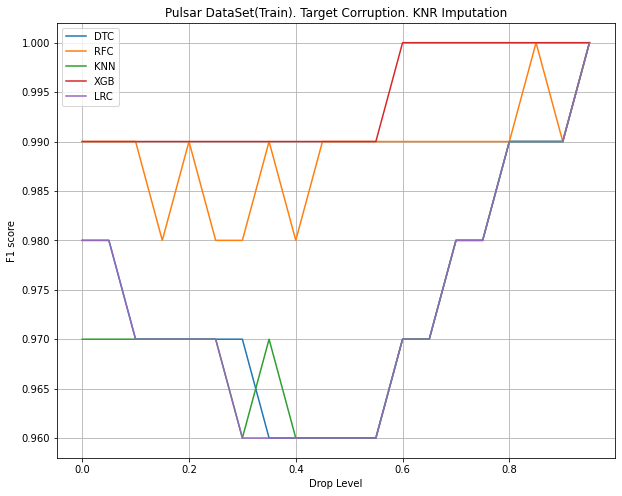

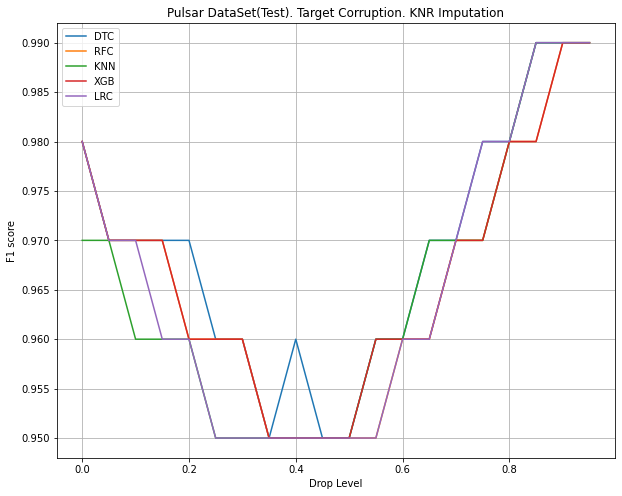

In [44]:
pulsar_train_knn, pulsar_test_knn = corrupt_target(20, X, y, clfs, est = KNeighborsRegressor())
pd.DataFrame(pulsar_train_knn).to_csv('PulsarF1TrainScoresKNN.csv', index = False)
pd.DataFrame(pulsar_test_knn).to_csv('PulsarF1TestScoresKNN.csv', index = False)
plot_results(pulsar_train_knn, 'Pulsar', 'KNR', test = False)
plot_results(pulsar_test_knn, 'Pulsar', 'KNR', test = True)

0.0
([0.98, 0.99, 0.97, 0.99, 0.98], [0.98, 0.98, 0.97, 0.98, 0.98])
0.05
([0.98, 0.99, 0.97, 0.99, 0.98], [0.97, 0.97, 0.97, 0.97, 0.97])
0.1
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.96, 0.97, 0.97])
0.15
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.97, 0.96, 0.96, 0.96])
0.2
([0.97, 0.99, 0.97, 0.99, 0.97], [0.97, 0.96, 0.96, 0.96, 0.96])
0.25
([0.96, 0.99, 0.96, 0.99, 0.96], [0.96, 0.96, 0.95, 0.95, 0.96])
0.3
([0.96, 0.98, 0.96, 0.99, 0.96], [0.96, 0.96, 0.95, 0.95, 0.96])
0.35
([0.96, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.4
([0.97, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.45
([0.96, 0.99, 0.96, 0.99, 0.96], [0.96, 0.95, 0.95, 0.95, 0.95])
0.5
([0.96, 0.99, 0.97, 0.99, 0.96], [0.95, 0.95, 0.95, 0.95, 0.95])
0.55
([0.96, 0.99, 0.97, 1.0, 0.96], [0.96, 0.95, 0.96, 0.95, 0.96])
0.6
([0.97, 0.99, 0.97, 1.0, 0.96], [0.96, 0.96, 0.96, 0.96, 0.96])
0.65
([0.97, 0.99, 0.97, 0.99, 0.97], [0.96, 0.96, 0.96, 0.96, 0.96])
0.7
([0.98, 0.99, 0.98, 0.99,

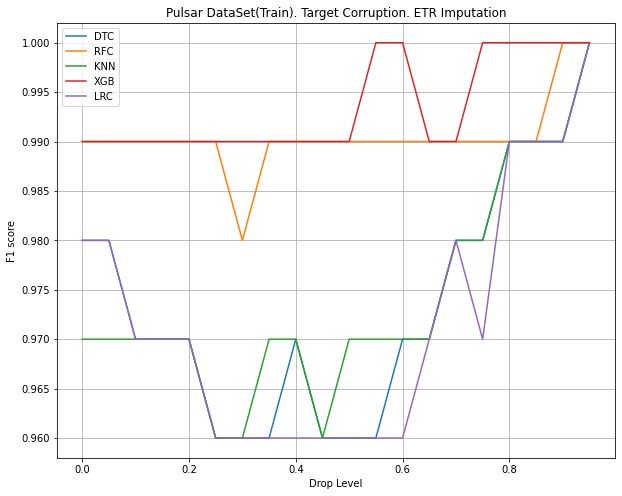

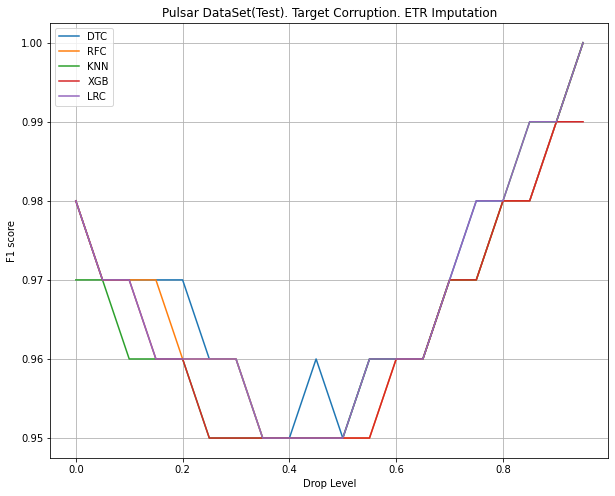

In [45]:
pulsar_train_extra, pulsar_test_extra = corrupt_target(20, X, y, clfs, est = ExtraTreesRegressor())
pd.DataFrame(pulsar_train_extra).to_csv('PulsarF1TrainScoresExtra.csv', index = False)
pd.DataFrame(pulsar_test_extra).to_csv('PulsarF1TestScoresExtra.csv', index = False)
plot_results(pulsar_train_extra, 'Pulsar', 'ETR', test = False)
plot_results(pulsar_test_extra, 'Pulsar', 'ETR', test = True)

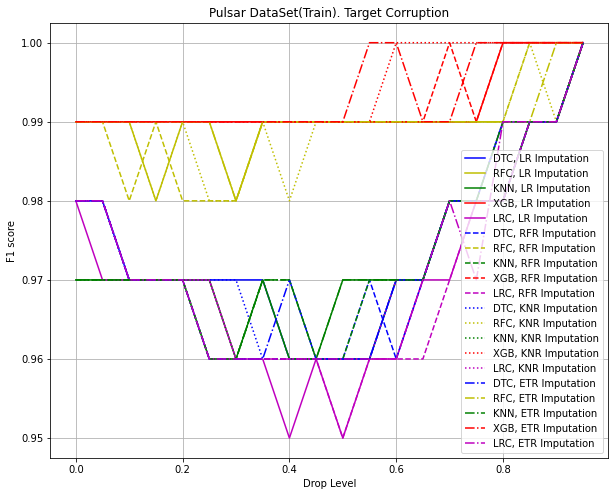

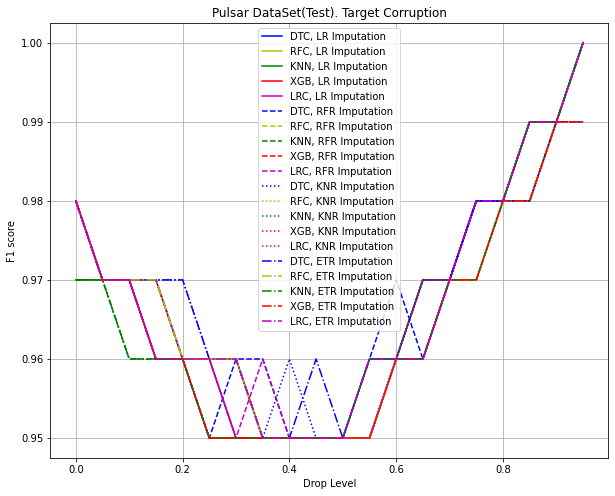

In [46]:
plot_all_results(pulsar_train, pulsar_train_dt, pulsar_train_knn, pulsar_train_extra, 'Pulsar', test = False)
plot_all_results(pulsar_test, pulsar_test_dt, pulsar_test_knn, pulsar_test_extra, 'Pulsar', test = True)

0.0
([1.0, 1.0, 0.98, 1.0, 1.0], [1.0, 1.0, 0.98, 1.0, 1.0])
0.05
([0.98, 0.98, 0.96, 0.98, 0.98], [0.98, 0.98, 0.96, 0.98, 0.98])
0.1
([0.96, 0.96, 0.94, 0.96, 0.96], [0.95, 0.95, 0.93, 0.95, 0.95])
0.15
([0.94, 0.94, 0.92, 0.94, 0.94], [0.93, 0.93, 0.91, 0.93, 0.93])
0.2
([0.92, 0.92, 0.92, 0.92, 0.92], [0.91, 0.91, 0.88, 0.91, 0.91])
0.25
([0.89, 0.89, 0.89, 0.89, 0.89], [0.89, 0.89, 0.85, 0.89, 0.88])
0.3
([0.87, 0.87, 0.88, 0.87, 0.87], [0.86, 0.86, 0.82, 0.86, 0.86])
0.35
([0.85, 0.85, 0.87, 0.86, 0.84], [0.84, 0.84, 0.8, 0.84, 0.84])
0.4
([0.83, 0.83, 0.86, 0.84, 0.82], [0.82, 0.82, 0.79, 0.81, 0.81])
0.45
([0.8, 0.82, 0.85, 0.83, 0.79], [0.79, 0.79, 0.77, 0.79, 0.79])
0.5
([0.79, 0.83, 0.86, 0.85, 0.78], [0.77, 0.77, 0.77, 0.77, 0.77])
0.55
([0.81, 0.81, 0.87, 0.84, 0.79], [0.79, 0.8, 0.77, 0.79, 0.79])
0.6
([0.83, 0.83, 0.86, 0.84, 0.83], [0.82, 0.82, 0.79, 0.82, 0.82])
0.65
([0.85, 0.84, 0.88, 0.85, 0.84], [0.84, 0.84, 0.81, 0.84, 0.84])
0.7
([0.87, 0.87, 0.89, 0.87, 0.87], [

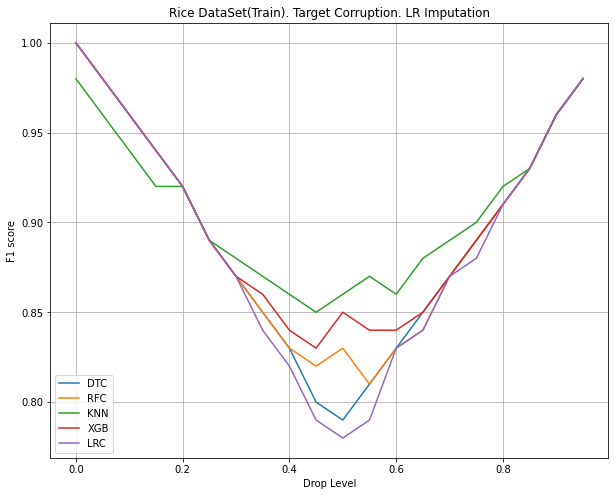

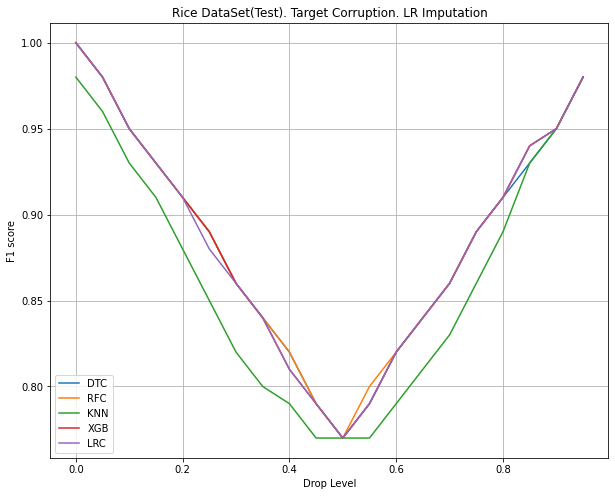

In [47]:
X = pd.read_csv('Rice_features.csv', index_col= 0)
y = pd.read_csv('Rice_labels.csv', index_col = 0)
n_features = X.shape[1]
tree = DecisionTreeClassifier(random_state=0, max_depth = 5)
forst = RandomForestClassifier(random_state=0, n_jobs = -1, max_depth= 5,  n_estimators = 30, max_features = 5)
knn = KNeighborsClassifier(n_neighbors = 5, n_jobs=-1)
xgvClf = xgb.XGBClassifier(random_state=0,  max_depth = 5, n_estimators=30)
logReg = LogisticRegression(random_state=0, C=1, n_jobs = -1)

clfs = [tree,
        forst, 
        knn,
        xgvClf,
        logReg
       ]

rice_train, rice_test = corrupt_target(20, X, y, clfs, est = None)
pd.DataFrame(rice_train).to_csv('RiceF1TrainScores.csv', index = False)
pd.DataFrame(rice_test).to_csv('RiceF1TestScores.csv', index = False)
plot_results(rice_train, 'Rice', 'LR', test = False)
plot_results(rice_test, 'Rice', 'LR', test = True)

0.0
([1.0, 1.0, 0.98, 1.0, 1.0], [1.0, 1.0, 0.98, 1.0, 1.0])
0.05
([0.98, 0.98, 0.96, 0.98, 0.97], [0.98, 0.98, 0.96, 0.98, 0.98])
0.1
([0.96, 0.96, 0.94, 0.96, 0.96], [0.95, 0.96, 0.93, 0.96, 0.95])
0.15
([0.93, 0.93, 0.92, 0.93, 0.93], [0.93, 0.93, 0.91, 0.93, 0.93])
0.2
([0.92, 0.92, 0.91, 0.92, 0.91], [0.91, 0.91, 0.88, 0.91, 0.91])
0.25
([0.89, 0.89, 0.89, 0.89, 0.89], [0.88, 0.89, 0.85, 0.89, 0.88])
0.3
([0.86, 0.86, 0.87, 0.86, 0.86], [0.86, 0.86, 0.82, 0.86, 0.86])
0.35
([0.85, 0.85, 0.87, 0.85, 0.84], [0.84, 0.84, 0.8, 0.84, 0.84])
0.4
([0.83, 0.84, 0.86, 0.84, 0.82], [0.81, 0.81, 0.78, 0.81, 0.81])
0.45
([0.81, 0.83, 0.86, 0.85, 0.8], [0.78, 0.79, 0.77, 0.79, 0.79])
0.5
([0.79, 0.83, 0.85, 0.84, 0.77], [0.78, 0.78, 0.77, 0.78, 0.77])
0.55
([0.81, 0.82, 0.86, 0.84, 0.8], [0.8, 0.8, 0.78, 0.79, 0.8])
0.6
([0.83, 0.83, 0.87, 0.85, 0.82], [0.82, 0.82, 0.79, 0.82, 0.82])
0.65
([0.85, 0.85, 0.88, 0.86, 0.85], [0.84, 0.84, 0.81, 0.84, 0.84])
0.7
([0.87, 0.87, 0.89, 0.88, 0.87], [0.8

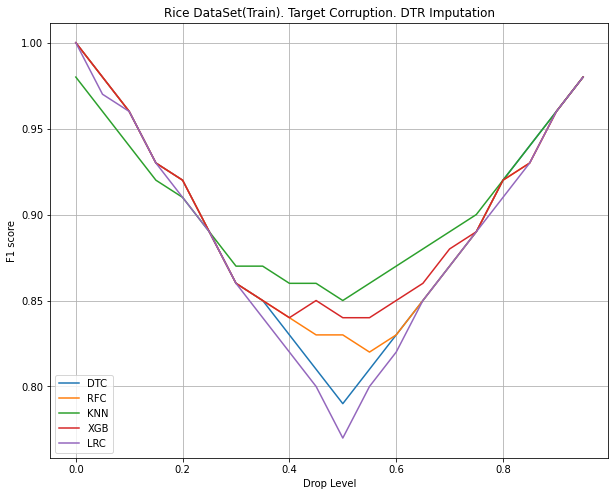

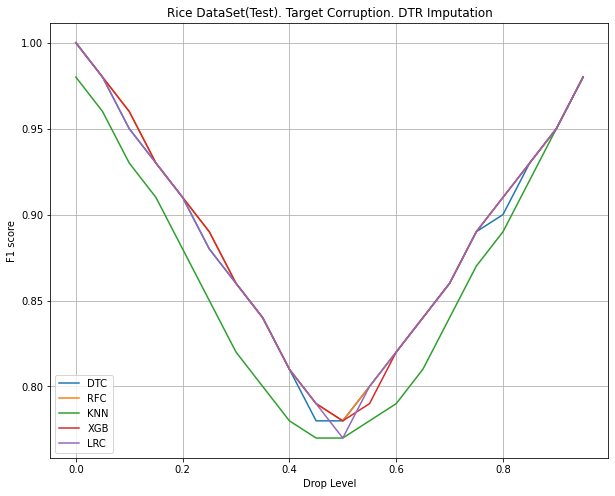

In [48]:
rice_train_forest, rice_test_forest = corrupt_target(20, X, y, clfs, est = DecisionTreeRegressor())
pd.DataFrame(rice_train_forest).to_csv('RiceF1TrainScoresDT.csv', index = False)
pd.DataFrame(rice_test_forest).to_csv('RiceF1TestScoresDT.csv', index = False)
plot_results(rice_train_forest, 'Rice', 'DTR', test = False)
plot_results(rice_test_forest, 'Rice', 'DTR', test = True)

0.0
([1.0, 1.0, 0.98, 1.0, 1.0], [1.0, 1.0, 0.98, 1.0, 1.0])
0.05
([0.98, 0.98, 0.96, 0.98, 0.98], [0.97, 0.98, 0.95, 0.97, 0.97])
0.1
([0.96, 0.96, 0.94, 0.96, 0.95], [0.96, 0.96, 0.93, 0.96, 0.95])
0.15
([0.94, 0.93, 0.92, 0.93, 0.93], [0.93, 0.93, 0.91, 0.93, 0.93])
0.2
([0.91, 0.91, 0.9, 0.91, 0.91], [0.91, 0.91, 0.87, 0.91, 0.91])
0.25
([0.89, 0.89, 0.89, 0.89, 0.88], [0.88, 0.88, 0.85, 0.88, 0.88])
0.3
([0.87, 0.87, 0.88, 0.87, 0.87], [0.86, 0.86, 0.83, 0.86, 0.86])
0.35
([0.85, 0.85, 0.87, 0.85, 0.84], [0.84, 0.84, 0.8, 0.84, 0.84])
0.4
([0.82, 0.83, 0.86, 0.84, 0.82], [0.82, 0.82, 0.78, 0.81, 0.81])
0.45
([0.81, 0.82, 0.86, 0.83, 0.8], [0.79, 0.79, 0.77, 0.79, 0.79])
0.5
([0.8, 0.83, 0.85, 0.84, 0.78], [0.77, 0.77, 0.77, 0.77, 0.77])
0.55
([0.81, 0.82, 0.86, 0.84, 0.79], [0.8, 0.8, 0.77, 0.79, 0.78])
0.6
([0.83, 0.83, 0.87, 0.85, 0.82], [0.82, 0.82, 0.8, 0.82, 0.82])
0.65
([0.84, 0.84, 0.88, 0.85, 0.83], [0.84, 0.84, 0.8, 0.84, 0.84])
0.7
([0.87, 0.87, 0.89, 0.87, 0.87], [0.86,

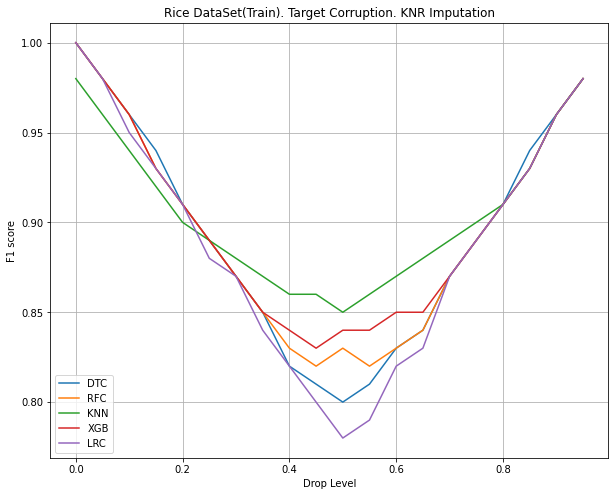

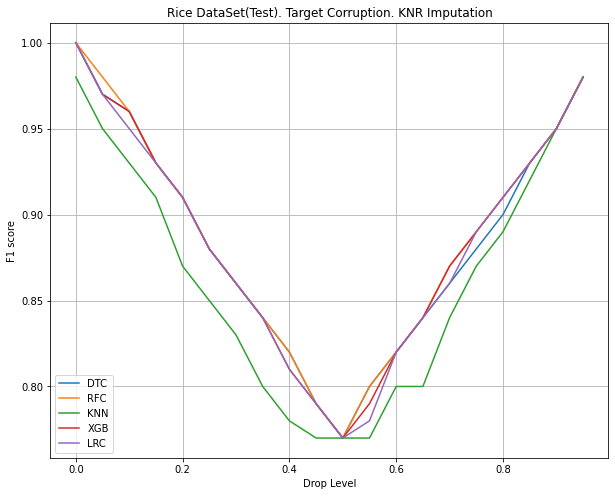

In [49]:
rice_train_knn, rice_test_knn = corrupt_target(20, X, y, clfs, est = KNeighborsRegressor())
pd.DataFrame(rice_train_knn).to_csv('RiceF1TrainScoresKNN.csv', index = False)
pd.DataFrame(rice_test_knn).to_csv('RiceF1TestScoresKNN.csv', index = False)
plot_results(rice_train_knn, 'Rice', 'KNR', test = False)
plot_results(rice_test_knn, 'Rice', 'KNR', test = True)

0.0
([1.0, 1.0, 0.98, 1.0, 1.0], [1.0, 1.0, 0.98, 1.0, 1.0])
0.05
([0.98, 0.98, 0.96, 0.98, 0.98], [0.97, 0.98, 0.95, 0.98, 0.97])
0.1
([0.96, 0.96, 0.94, 0.96, 0.95], [0.95, 0.96, 0.93, 0.96, 0.95])
0.15
([0.94, 0.94, 0.92, 0.94, 0.93], [0.93, 0.93, 0.91, 0.93, 0.93])
0.2
([0.92, 0.92, 0.91, 0.92, 0.92], [0.91, 0.91, 0.88, 0.91, 0.91])
0.25
([0.89, 0.89, 0.89, 0.89, 0.88], [0.89, 0.89, 0.85, 0.89, 0.89])
0.3
([0.87, 0.87, 0.88, 0.88, 0.87], [0.87, 0.87, 0.83, 0.87, 0.87])
0.35
([0.85, 0.85, 0.86, 0.85, 0.84], [0.85, 0.84, 0.81, 0.84, 0.84])
0.4
([0.83, 0.83, 0.86, 0.84, 0.82], [0.81, 0.82, 0.79, 0.82, 0.81])
0.45
([0.82, 0.83, 0.86, 0.83, 0.79], [0.79, 0.79, 0.77, 0.79, 0.79])
0.5
([0.8, 0.82, 0.85, 0.85, 0.78], [0.78, 0.77, 0.78, 0.77, 0.77])
0.55
([0.8, 0.82, 0.86, 0.82, 0.79], [0.8, 0.79, 0.77, 0.79, 0.79])
0.6
([0.82, 0.83, 0.87, 0.84, 0.82], [0.81, 0.82, 0.79, 0.81, 0.82])
0.65
([0.85, 0.85, 0.88, 0.85, 0.84], [0.84, 0.84, 0.81, 0.84, 0.84])
0.7
([0.88, 0.88, 0.89, 0.88, 0.87], [

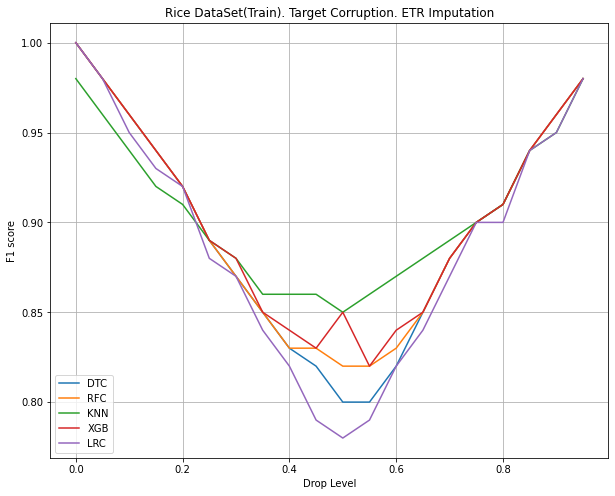

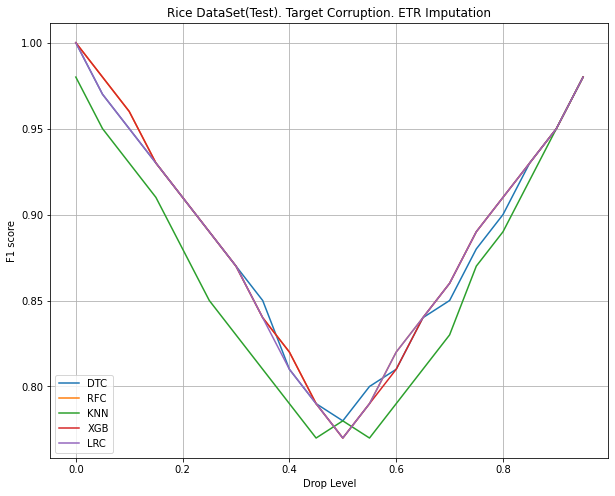

In [50]:
rice_train_extra, rice_test_extra = corrupt_target(20, X, y, clfs, est = ExtraTreesRegressor())
pd.DataFrame(rice_train_extra).to_csv('RiceF1TrainScoresETR.csv', index = False)
pd.DataFrame(rice_test_extra).to_csv('RiceF1TestScoresETR.csv', index = False)
plot_results(rice_train_extra, 'Rice', 'ETR', test = False)
plot_results(rice_test_extra, 'Rice', 'ETR', test = True)

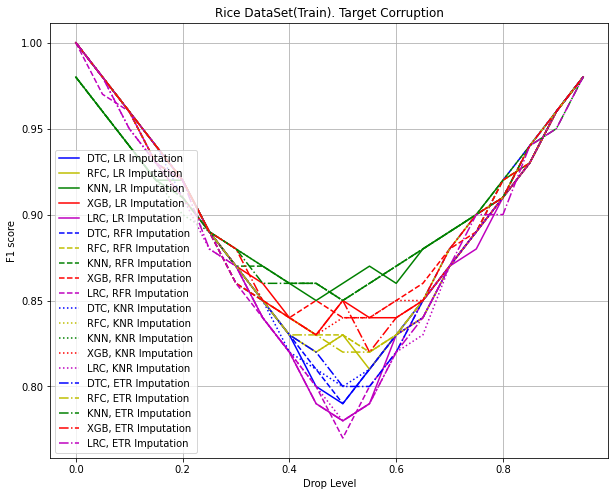

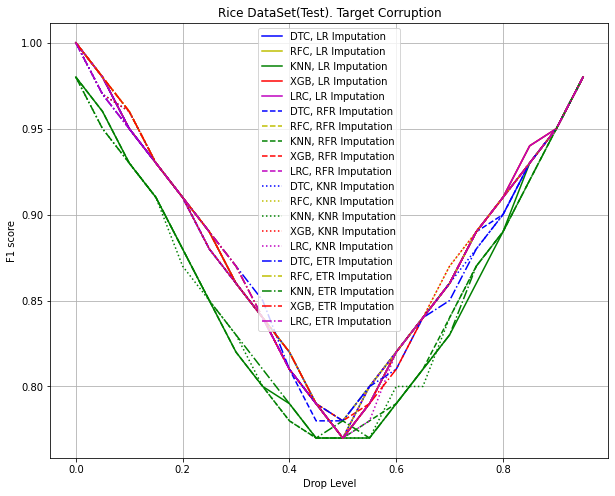

In [51]:
plot_all_results(rice_train, rice_train_forest, rice_train_knn, rice_train_extra, 'Rice', test = False)
plot_all_results(rice_test, rice_test_forest, rice_test_knn, rice_test_extra, 'Rice', test = True)

0.0
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.9])
0.05
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.1
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.15
([0.92, 0.99, 0.92, 0.93, 0.91], [0.91, 0.9, 0.91, 0.91, 0.91])
0.2
([0.92, 0.99, 0.93, 0.93, 0.91], [0.91, 0.9, 0.91, 0.91, 0.91])
0.25
([0.92, 0.99, 0.93, 0.93, 0.92], [0.92, 0.91, 0.92, 0.91, 0.91])
0.3
([0.93, 0.99, 0.93, 0.94, 0.92], [0.92, 0.91, 0.92, 0.92, 0.92])
0.35
([0.93, 0.99, 0.93, 0.94, 0.92], [0.92, 0.92, 0.92, 0.92, 0.92])
0.4
([0.94, 0.99, 0.94, 0.94, 0.93], [0.93, 0.92, 0.93, 0.93, 0.93])
0.45
([0.94, 0.99, 0.94, 0.94, 0.94], [0.94, 0.93, 0.94, 0.93, 0.94])
0.5
([0.94, 0.99, 0.94, 0.95, 0.94], [0.94, 0.93, 0.94, 0.94, 0.94])
0.55
([0.95, 0.99, 0.95, 0.95, 0.94], [0.95, 0.94, 0.95, 0.94, 0.94])
0.6
([0.96, 0.99, 0.96, 0.96, 0.95], [0.95, 0.95, 0.95, 0.95, 0.95])
0.65
([0.96, 0.99, 0.96, 0.96, 0.96], [0.96, 0.96, 0.96, 0.96, 0.96])
0.7
([0.97, 0.99, 0.97, 0.97, 0.97],

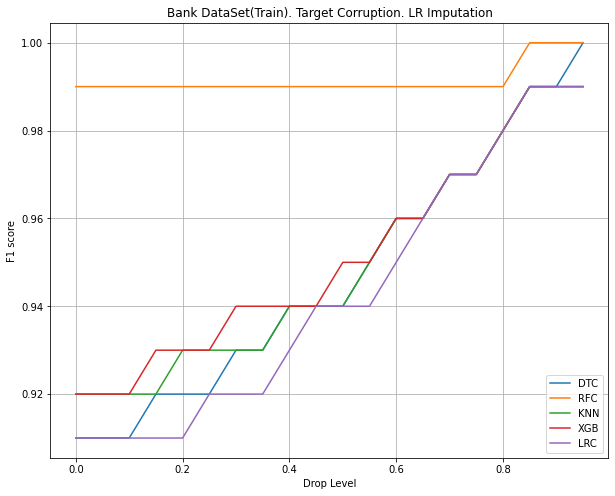

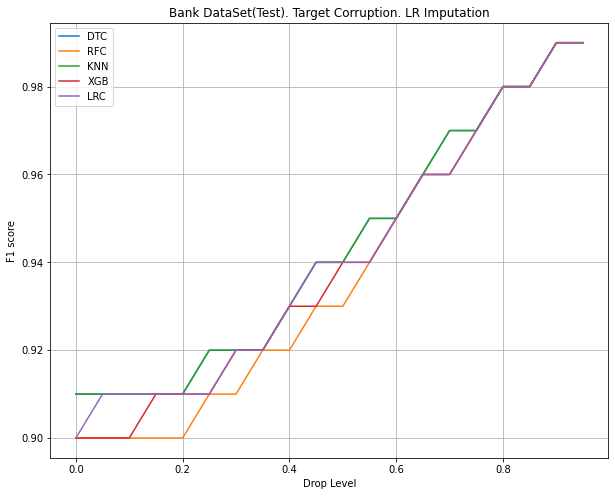

In [52]:
y = pd.read_csv('bank_data_labels.csv')
X = pd.read_csv('bank_data_features.csv')

dtc = DecisionTreeClassifier(max_depth=4)
rfc = RandomForestClassifier(n_estimators=5)
xgb_с = xgb.XGBClassifier()
knc = KNeighborsClassifier()
lr = LogisticRegression()

clfs = [dtc,
        rfc,
        xgb_с,
        knc,
        lr
       ]


bank_train, bank_test = corrupt_target(20, X, y, clfs, est = None)
pd.DataFrame(bank_train).to_csv('BankF1TrainScoresLR.csv', index = False)
pd.DataFrame(bank_test).to_csv('BankF1TestScoresLR.csv', index = False)
plot_results(bank_train, 'Bank', 'LR', test = False)
plot_results(bank_test, 'Bank', 'LR', test = True)

0.0
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.89, 0.91, 0.9, 0.9])
0.05
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.1
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.15
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.2
([0.92, 0.99, 0.92, 0.93, 0.91], [0.91, 0.91, 0.91, 0.91, 0.91])
0.25
([0.92, 0.99, 0.93, 0.93, 0.92], [0.92, 0.91, 0.92, 0.91, 0.92])
0.3
([0.93, 0.99, 0.93, 0.94, 0.92], [0.92, 0.91, 0.92, 0.91, 0.92])
0.35
([0.93, 0.99, 0.93, 0.93, 0.93], [0.93, 0.92, 0.92, 0.92, 0.92])
0.4
([0.94, 0.99, 0.94, 0.94, 0.93], [0.93, 0.92, 0.93, 0.93, 0.93])
0.45
([0.94, 0.99, 0.94, 0.95, 0.94], [0.94, 0.93, 0.94, 0.93, 0.94])
0.5
([0.95, 0.99, 0.95, 0.95, 0.94], [0.94, 0.94, 0.94, 0.94, 0.94])
0.55
([0.95, 0.99, 0.95, 0.96, 0.95], [0.95, 0.94, 0.95, 0.94, 0.95])
0.6
([0.95, 0.99, 0.95, 0.96, 0.95], [0.95, 0.95, 0.95, 0.95, 0.95])
0.65
([0.96, 0.99, 0.96, 0.96, 0.96], [0.96, 0.96, 0.96, 0.96, 0.96])
0.7
([0.96, 0.99, 0.96, 0.97, 0.96]

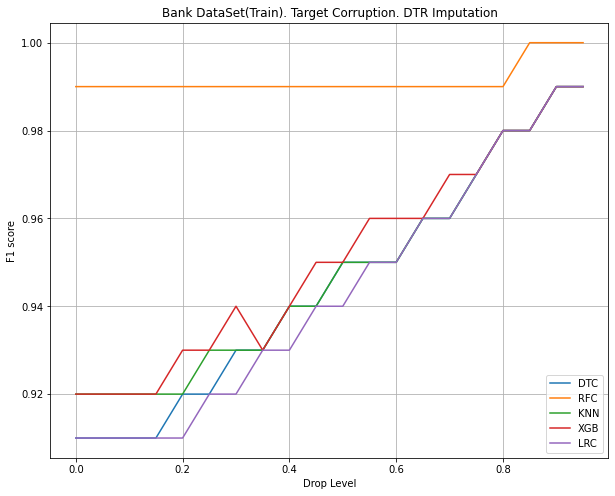

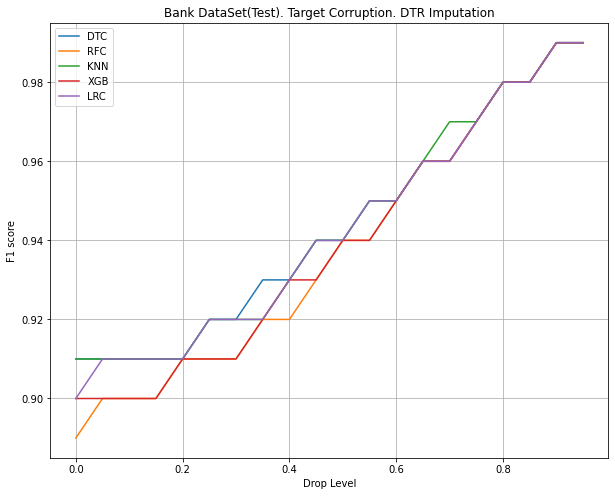

In [53]:
bank_train_forest, bank_test_forest = corrupt_target(20, X, y, clfs, est = DecisionTreeRegressor())
pd.DataFrame(bank_train_forest).to_csv('BankF1TrainScoresDTR.csv', index = False)
pd.DataFrame(bank_test_forest).to_csv('BankF1TestScoresDTR.csv', index = False)
plot_results(bank_train_forest, 'Bank', 'DTR', test = False)
plot_results(bank_test_forest, 'Bank', 'DTR', test = True)

0.0
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.9])
0.05
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.9])
0.1
([0.91, 0.99, 0.92, 0.93, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.15
([0.92, 0.99, 0.92, 0.93, 0.91], [0.91, 0.9, 0.91, 0.91, 0.91])
0.2
([0.92, 0.99, 0.93, 0.93, 0.92], [0.91, 0.91, 0.91, 0.91, 0.91])
0.25
([0.92, 0.99, 0.93, 0.93, 0.92], [0.92, 0.91, 0.92, 0.91, 0.92])
0.3
([0.93, 0.99, 0.93, 0.93, 0.92], [0.92, 0.91, 0.92, 0.92, 0.92])
0.35
([0.93, 0.99, 0.94, 0.94, 0.93], [0.92, 0.92, 0.93, 0.92, 0.92])
0.4
([0.94, 0.99, 0.94, 0.94, 0.93], [0.93, 0.92, 0.93, 0.93, 0.93])
0.45
([0.94, 0.99, 0.94, 0.94, 0.93], [0.94, 0.93, 0.94, 0.93, 0.94])
0.5
([0.95, 0.99, 0.95, 0.95, 0.94], [0.94, 0.94, 0.94, 0.94, 0.94])
0.55
([0.95, 0.99, 0.95, 0.95, 0.95], [0.95, 0.94, 0.95, 0.95, 0.95])
0.6
([0.95, 0.99, 0.95, 0.96, 0.95], [0.96, 0.95, 0.95, 0.95, 0.95])
0.65
([0.96, 0.99, 0.96, 0.96, 0.96], [0.96, 0.96, 0.96, 0.96, 0.96])
0.7
([0.97, 0.99, 0.97, 0.97, 0.97],

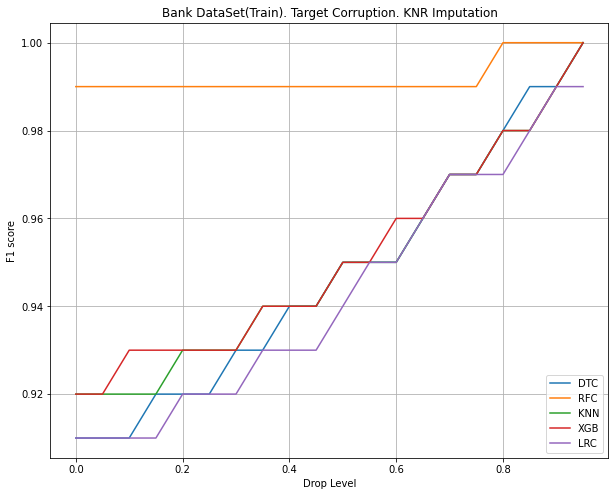

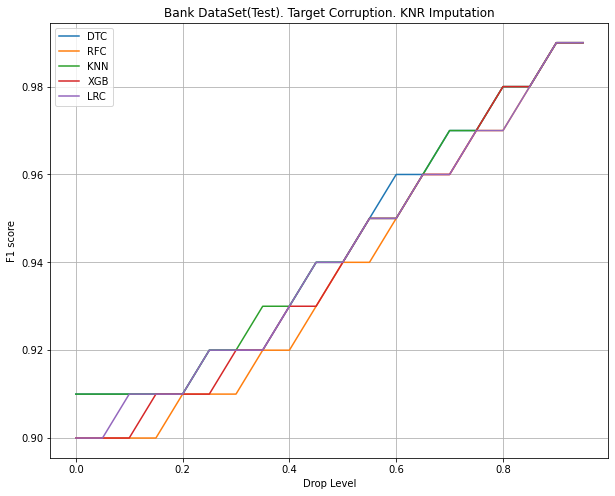

In [54]:
bank_train_knn, bank_test_knn = corrupt_target(20, X, y, clfs, est = KNeighborsRegressor())
pd.DataFrame(bank_train_knn).to_csv('BankF1TrainScoresKNR.csv', index = False)
pd.DataFrame(bank_test_knn).to_csv('BankF1TestScoresKNR.csv', index = False)
plot_results(bank_train_knn, 'Bank', 'KNR', test = False)
plot_results(bank_test_knn, 'Bank', 'KNR', test = True)

0.0
([0.91, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.9])
0.05
([0.91, 0.98, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.9, 0.9])
0.1
([0.92, 0.99, 0.92, 0.93, 0.91], [0.91, 0.9, 0.91, 0.9, 0.91])
0.15
([0.92, 0.99, 0.92, 0.92, 0.91], [0.91, 0.9, 0.91, 0.91, 0.91])
0.2
([0.92, 0.99, 0.93, 0.93, 0.92], [0.91, 0.91, 0.91, 0.91, 0.91])
0.25
([0.92, 0.99, 0.93, 0.93, 0.92], [0.92, 0.91, 0.92, 0.91, 0.92])
0.3
([0.92, 0.99, 0.93, 0.93, 0.92], [0.92, 0.91, 0.92, 0.92, 0.92])
0.35
([0.93, 0.99, 0.93, 0.94, 0.93], [0.93, 0.92, 0.93, 0.92, 0.92])
0.4
([0.93, 0.99, 0.94, 0.94, 0.93], [0.93, 0.93, 0.93, 0.93, 0.93])
0.45
([0.94, 0.99, 0.94, 0.94, 0.93], [0.94, 0.93, 0.94, 0.93, 0.93])
0.5
([0.94, 0.99, 0.95, 0.95, 0.94], [0.94, 0.93, 0.94, 0.94, 0.94])
0.55
([0.95, 0.99, 0.95, 0.95, 0.95], [0.95, 0.94, 0.95, 0.94, 0.95])
0.6
([0.96, 0.99, 0.96, 0.96, 0.95], [0.95, 0.95, 0.95, 0.95, 0.95])
0.65
([0.96, 0.99, 0.96, 0.96, 0.96], [0.96, 0.95, 0.96, 0.96, 0.96])
0.7
([0.97, 0.99, 0.97, 0.97, 0.96],

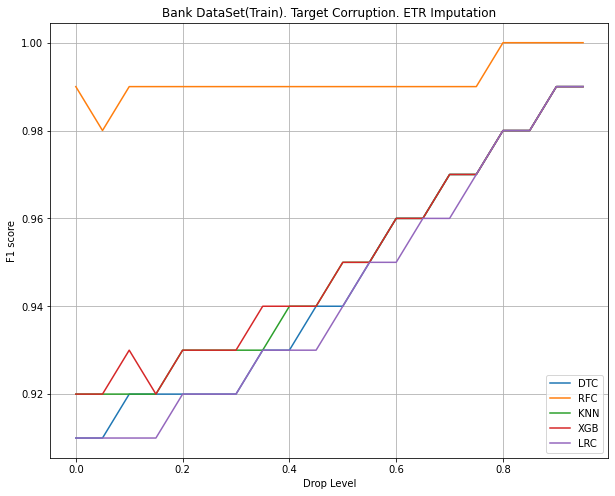

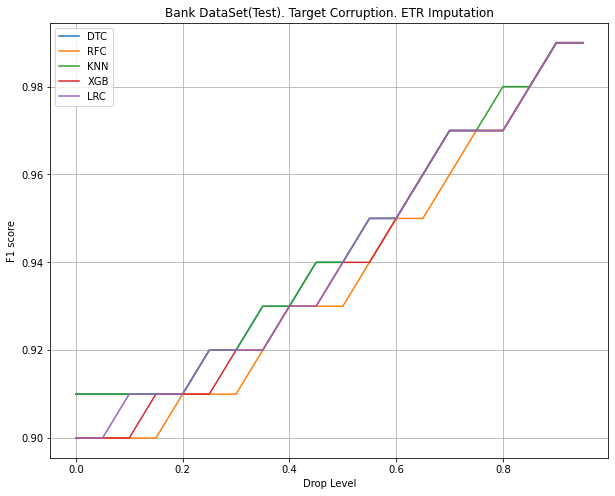

In [55]:
bank_train_extra, bank_test_extra = corrupt_target(20, X, y, clfs, est = ExtraTreesRegressor())
pd.DataFrame(bank_train_extra).to_csv('BankF1TrainScoresETR.csv', index = False)
pd.DataFrame(bank_test_extra).to_csv('BankF1TestScoresETR.csv', index = False)
plot_results(bank_train_extra, 'Bank', 'ETR', test = False)
plot_results(bank_test_extra, 'Bank', 'ETR', test = True)

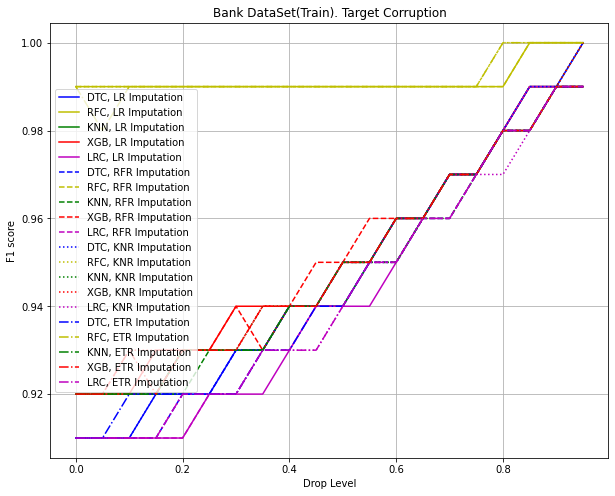

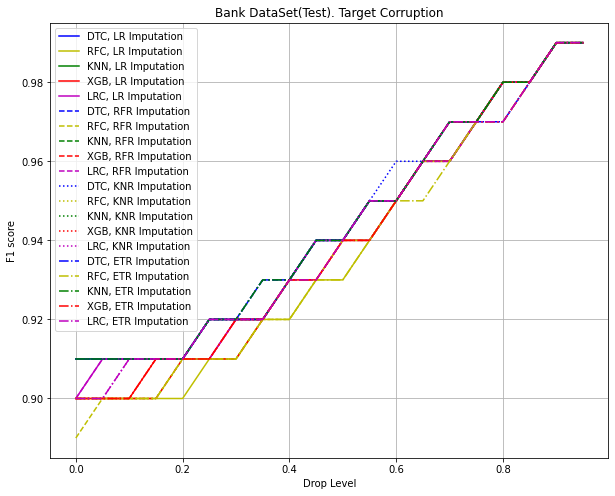

In [56]:
plot_all_results(bank_train, bank_train_forest, bank_train_knn, bank_train_extra, 'Bank', test = False)
plot_all_results(bank_test, bank_test_forest, bank_test_knn, bank_test_extra, 'Bank', test = True)

0.0
([0.98, 0.99, 0.96, 1.0, 0.96], [0.97, 0.97, 0.94, 0.97, 0.96])
0.05
([0.95, 0.97, 0.94, 0.98, 0.85], [0.94, 0.94, 0.9, 0.94, 0.85])
0.1
([0.92, 0.94, 0.91, 0.95, 0.77], [0.9, 0.91, 0.86, 0.91, 0.76])
0.15
([0.89, 0.91, 0.88, 0.94, 0.72], [0.87, 0.88, 0.82, 0.88, 0.72])
0.2
([0.86, 0.9, 0.87, 0.92, 0.69], [0.84, 0.85, 0.78, 0.85, 0.69])
0.25
([0.82, 0.88, 0.85, 0.9, 0.66], [0.8, 0.81, 0.74, 0.81, 0.66])
0.3
([0.81, 0.87, 0.84, 0.9, 0.65], [0.78, 0.78, 0.72, 0.78, 0.65])
0.35
([0.77, 0.88, 0.83, 0.92, 0.63], [0.74, 0.74, 0.69, 0.74, 0.63])
0.4
([0.75, 0.91, 0.82, 0.93, 0.64], [0.71, 0.71, 0.68, 0.7, 0.64])
0.45
([0.72, 0.94, 0.82, 0.95, 0.64], [0.69, 0.69, 0.66, 0.68, 0.65])
0.5
([0.73, 0.97, 0.83, 0.97, 0.66], [0.67, 0.68, 0.66, 0.68, 0.67])
0.55
([0.73, 0.95, 0.83, 0.94, 0.69], [0.7, 0.69, 0.67, 0.69, 0.69])
0.6
([0.77, 0.89, 0.84, 0.93, 0.74], [0.72, 0.73, 0.69, 0.72, 0.73])
0.65
([0.8, 0.88, 0.85, 0.92, 0.78], [0.76, 0.76, 0.72, 0.76, 0.76])
0.7
([0.81, 0.86, 0.85, 0.9, 0.8], [0

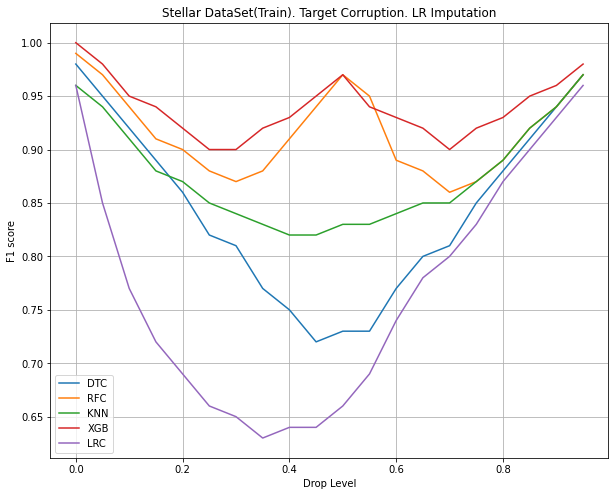

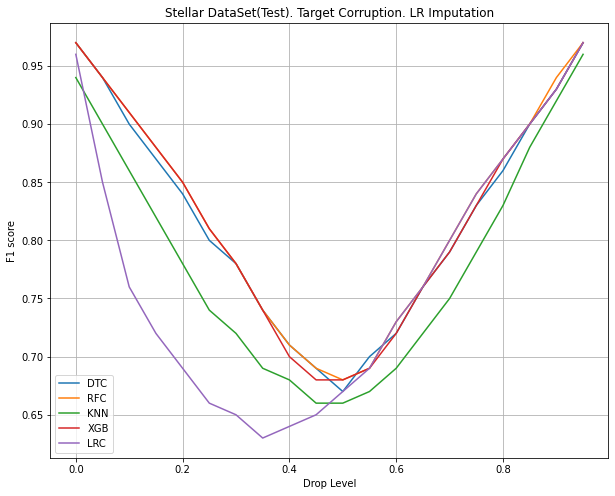

In [57]:
X = pd.read_csv('stellar_features.csv', index_col = 0)
y = pd.read_csv('stellar_labels.csv', index_col = 0)


tree = DecisionTreeClassifier(random_state=0, max_depth = 9)
forst = RandomForestClassifier(random_state=0, max_depth= 14,  n_estimators = 90)

knn = KNeighborsClassifier(n_neighbors = 3)
xgvClf = xgb.XGBClassifier(random_state=0, learning_rate=0.1, max_depth = 12, n_estimators=100)
logReg = LogisticRegression(random_state=0, C=2010)


clfs = [tree,
        forst, 
        knn,
        xgvClf,
        logReg
       ]


stellar_train, stellar_test = corrupt_target(20, X, y, clfs, est = None)
pd.DataFrame(stellar_train).to_csv('StellarF1TrainScoresLR.csv', index = False)
pd.DataFrame(stellar_test).to_csv('StellarF1TestScoresLR.csv', index = False)
plot_results(stellar_train, 'Stellar', 'LR', test = False)
plot_results(stellar_test, 'Stellar', 'LR', test = True)

0.0
([0.98, 0.99, 0.96, 1.0, 0.96], [0.97, 0.97, 0.94, 0.97, 0.96])
0.05
([0.95, 0.97, 0.93, 0.98, 0.83], [0.93, 0.94, 0.9, 0.94, 0.84])
0.1
([0.92, 0.94, 0.91, 0.96, 0.77], [0.9, 0.91, 0.86, 0.91, 0.77])
0.15
([0.89, 0.91, 0.88, 0.94, 0.72], [0.87, 0.88, 0.82, 0.88, 0.72])
0.2
([0.86, 0.9, 0.86, 0.92, 0.69], [0.84, 0.85, 0.79, 0.84, 0.69])
0.25
([0.84, 0.88, 0.86, 0.91, 0.67], [0.81, 0.81, 0.75, 0.81, 0.67])
0.3
([0.81, 0.88, 0.84, 0.91, 0.65], [0.77, 0.78, 0.72, 0.77, 0.65])
0.35
([0.78, 0.88, 0.83, 0.91, 0.64], [0.74, 0.75, 0.69, 0.74, 0.64])
0.4
([0.75, 0.91, 0.83, 0.93, 0.63], [0.72, 0.71, 0.67, 0.7, 0.63])
0.45
([0.73, 0.95, 0.82, 0.97, 0.65], [0.69, 0.69, 0.67, 0.68, 0.64])
0.5
([0.73, 0.97, 0.82, 0.97, 0.66], [0.67, 0.68, 0.66, 0.68, 0.67])
0.55
([0.74, 0.94, 0.83, 0.95, 0.69], [0.69, 0.69, 0.67, 0.69, 0.69])
0.6
([0.75, 0.91, 0.83, 0.92, 0.72], [0.73, 0.73, 0.69, 0.72, 0.72])
0.65
([0.78, 0.87, 0.84, 0.9, 0.76], [0.76, 0.77, 0.71, 0.76, 0.76])
0.7
([0.83, 0.87, 0.86, 0.91, 0.8

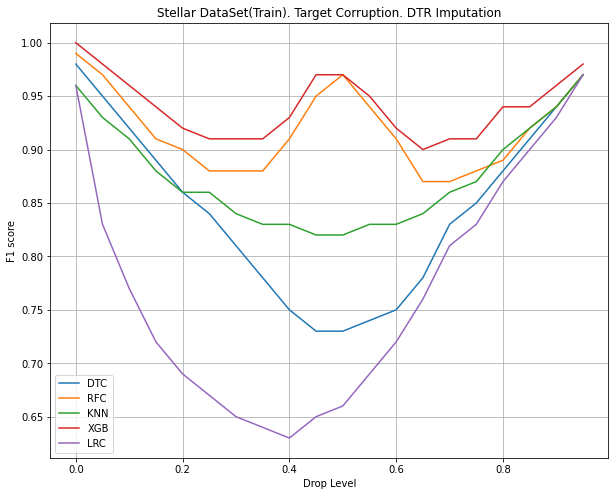

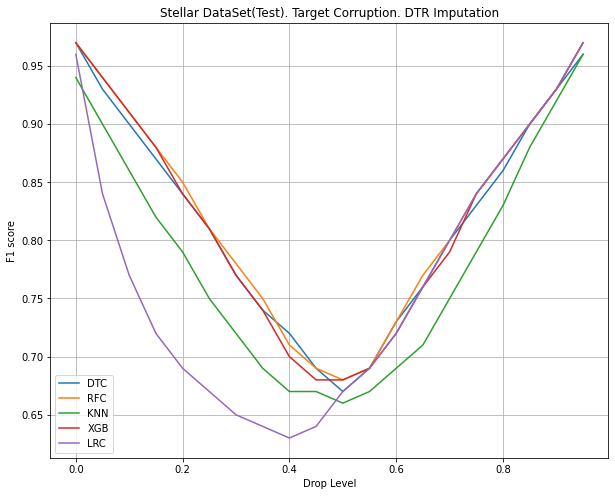

In [58]:
stellar_train_forest, stellar_test_forest = corrupt_target(20, X, y, clfs, est = DecisionTreeRegressor())
pd.DataFrame(stellar_train_forest).to_csv('StellarF1TrainScoresDTR.csv', index = False)
pd.DataFrame(stellar_test_forest).to_csv('StellarF1TestScoresDTR.csv', index = False)
plot_results(stellar_train_forest, 'Stellar', 'DTR', test = False)
plot_results(stellar_test_forest, 'Stellar', 'DTR', test = True)

0.0
([0.98, 0.99, 0.96, 1.0, 0.96], [0.97, 0.97, 0.94, 0.97, 0.96])
0.05
([0.95, 0.97, 0.93, 0.97, 0.83], [0.94, 0.94, 0.9, 0.94, 0.84])
0.1
([0.92, 0.94, 0.91, 0.95, 0.76], [0.9, 0.91, 0.86, 0.91, 0.76])
0.15
([0.89, 0.92, 0.89, 0.94, 0.72], [0.87, 0.88, 0.83, 0.88, 0.72])
0.2
([0.87, 0.9, 0.87, 0.92, 0.7], [0.84, 0.85, 0.79, 0.85, 0.69])
0.25
([0.84, 0.89, 0.86, 0.91, 0.67], [0.8, 0.82, 0.75, 0.81, 0.67])
0.3
([0.8, 0.88, 0.84, 0.91, 0.65], [0.77, 0.78, 0.71, 0.77, 0.64])
0.35
([0.78, 0.89, 0.83, 0.92, 0.63], [0.74, 0.74, 0.69, 0.74, 0.63])
0.4
([0.76, 0.91, 0.82, 0.93, 0.64], [0.71, 0.71, 0.67, 0.71, 0.64])
0.45
([0.73, 0.94, 0.82, 0.96, 0.65], [0.69, 0.68, 0.66, 0.68, 0.64])
0.5
([0.71, 0.97, 0.82, 0.96, 0.66], [0.67, 0.67, 0.67, 0.67, 0.67])
0.55
([0.73, 0.94, 0.83, 0.95, 0.69], [0.7, 0.7, 0.67, 0.69, 0.69])
0.6
([0.76, 0.9, 0.84, 0.94, 0.72], [0.73, 0.73, 0.69, 0.72, 0.73])
0.65
([0.79, 0.87, 0.85, 0.91, 0.77], [0.77, 0.77, 0.72, 0.76, 0.77])
0.7
([0.82, 0.87, 0.86, 0.91, 0.8], [

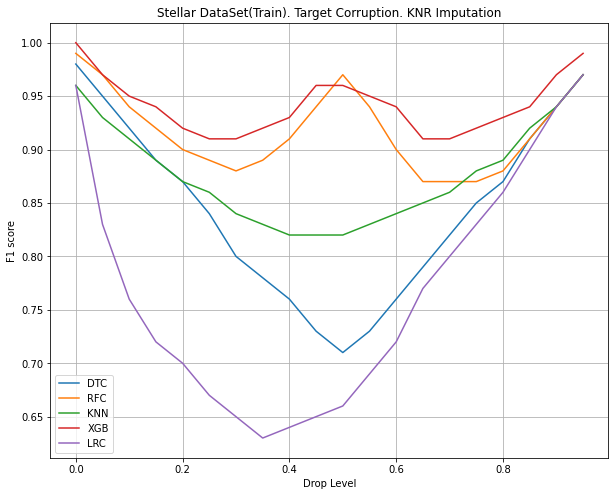

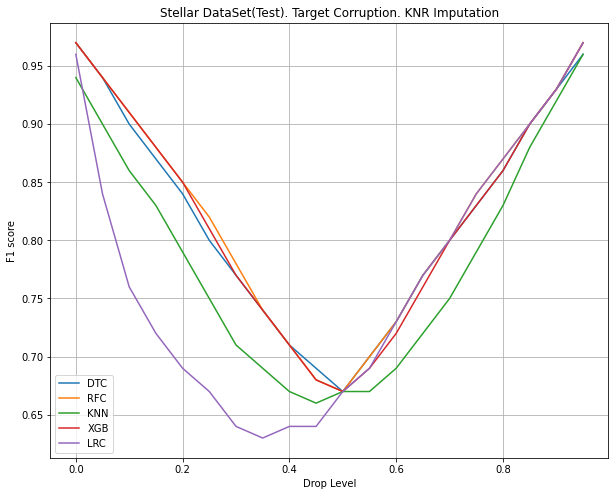

In [59]:
stellar_train_knn, stellar_test_knn = corrupt_target(20, X, y, clfs, est = KNeighborsRegressor())
pd.DataFrame(stellar_train_knn).to_csv('StellarF1TrainScoresKNN.csv', index = False)
pd.DataFrame(stellar_test_knn).to_csv('StellarF1TestScoresKNN.csv', index = False)
plot_results(stellar_train_knn, 'Stellar', 'KNR', test = False)
plot_results(stellar_test_knn, 'Stellar', 'KNR', test = True)

0.0
([0.98, 0.99, 0.96, 1.0, 0.96], [0.97, 0.97, 0.94, 0.97, 0.96])
0.05
([0.95, 0.97, 0.93, 0.98, 0.84], [0.93, 0.94, 0.9, 0.94, 0.84])
0.1
([0.93, 0.94, 0.91, 0.96, 0.78], [0.9, 0.91, 0.86, 0.91, 0.77])
0.15
([0.89, 0.92, 0.89, 0.94, 0.73], [0.87, 0.88, 0.82, 0.88, 0.73])
0.2
([0.86, 0.9, 0.87, 0.93, 0.69], [0.84, 0.85, 0.78, 0.85, 0.69])
0.25
([0.84, 0.88, 0.86, 0.92, 0.67], [0.81, 0.82, 0.75, 0.81, 0.67])
0.3
([0.8, 0.88, 0.84, 0.9, 0.64], [0.77, 0.78, 0.71, 0.77, 0.64])
0.35
([0.78, 0.88, 0.83, 0.92, 0.64], [0.74, 0.74, 0.69, 0.74, 0.63])
0.4
([0.75, 0.92, 0.83, 0.95, 0.64], [0.71, 0.71, 0.67, 0.7, 0.64])
0.45
([0.73, 0.95, 0.83, 0.96, 0.64], [0.68, 0.68, 0.66, 0.68, 0.64])
0.5
([0.72, 0.97, 0.82, 0.97, 0.67], [0.67, 0.67, 0.66, 0.67, 0.67])
0.55
([0.74, 0.94, 0.83, 0.95, 0.7], [0.7, 0.7, 0.67, 0.69, 0.69])
0.6
([0.76, 0.91, 0.83, 0.93, 0.72], [0.72, 0.73, 0.69, 0.71, 0.73])
0.65
([0.79, 0.88, 0.85, 0.92, 0.76], [0.76, 0.77, 0.71, 0.75, 0.76])
0.7
([0.82, 0.86, 0.85, 0.91, 0.8], [

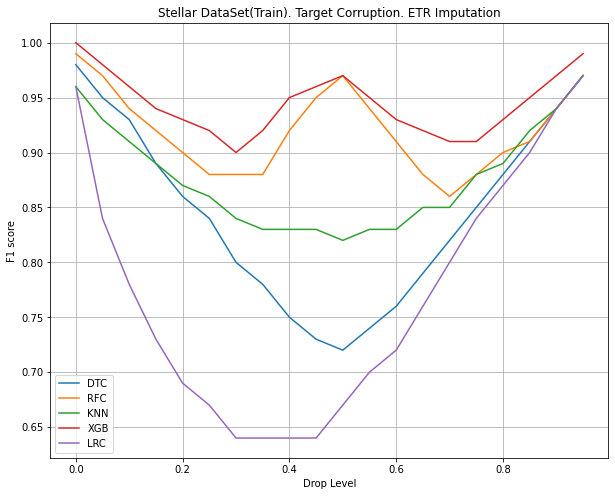

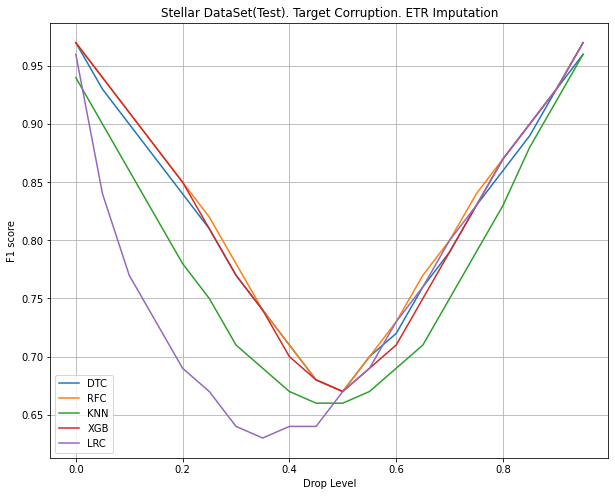

In [60]:
stellar_train_extra, stellar_test_extra = corrupt_target(20, X, y, clfs, est = ExtraTreesRegressor())
pd.DataFrame(stellar_train_extra).to_csv('StellarF1TrainScoresETR.csv', index = False)
pd.DataFrame(stellar_test_extra).to_csv('StellarF1TestScoresETR.csv', index = False)
plot_results(stellar_train_extra, 'Stellar', 'ETR', test = False)
plot_results(stellar_test_extra, 'Stellar', 'ETR', test = True)

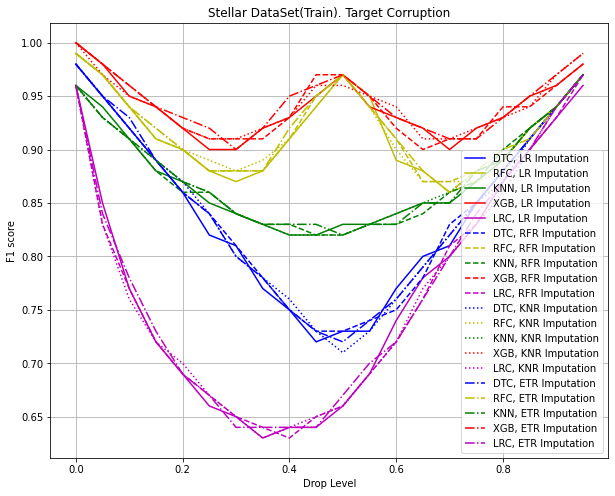

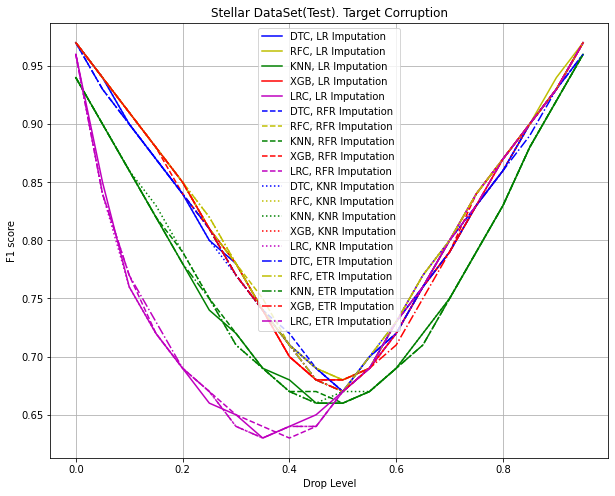

In [61]:
plot_all_results(stellar_train, stellar_train_forest, stellar_train_knn, stellar_train_extra, 'Stellar', test = False)
plot_all_results(stellar_test, stellar_test_forest, stellar_test_knn, stellar_test_extra, 'Stellar', test = True)